# Modeling DAU, WAU, MAU with Markov chain

Doubtlessly, DAU, WAU, and MAU are critical business metrics. An article ["How Duolingo reignited user growth"](https://www.lennysnewsletter.com/p/how-duolingo-reignited-user-growth) by [Jorge Mazal](https://www.linkedin.com/in/jorgemazal/), former CPO of Duolingo is #1 the Growth section of Lenny's Newsletter blog. In this article Jorge payed special attention to the methodology Duolingo used to model DAU metrics (see another article ["Meaningful metrics: how data sharpened the focus of product teams"](https://blog.duolingo.com/growth-model-duolingo/) by [Erin Gustafson](https://blog.duolingo.com/author/erin/)). This methodology has multiple strenghts but I focus here on how one can use it for DAU forecasting.

New year is coming soon, so many companies are planning their budgets for the next year these days. Cost estimations are often require DAU forecast. In this article I'll show you how you can get this prediction using the Duolingo's growth model and share a DAU & MAU "calculator" designed as a Google Spreadsheet calculator.

## Methodology

A quick recap on how the [Duolingo's growth model](https://blog.duolingo.com/growth-model-duolingo/) works. At day $d$ ($d=1,2,\ldots,$) of a user's lifetime the user can be in one of the following 7 (mutually-exclusive) states:

<table>
<thead><tr><th>state</th><th>d = 1</th><th>is active today</th><th>was active in [d-6, d-1]</th><th>was active in [d-29, d-7]</th><th>was active before d-30</th></tr></thead>
<tr><td>new</td><td>✅</td><td>❓</td><td>❌</td><td>❌</td><td>❌</td></tr>
<tr><td>current</td><td>❌</td><td>✅</td><td>✅</td><td>❓</td><td>❓</td></tr>
<tr><td>reactivated</td><td>❌</td><td>✅</td><td>❌</td><td>✅</td><td>❓</td></tr>
<tr><td>resurrected</td><td>❌</td><td>✅</td><td>❌</td><td>❌</td><td>✅</td></tr>
<tr><td>at_risk_wau</td><td>❌</td><td>❌</td><td>✅</td><td>❓</td><td>❓</td></tr>
<tr><td>at_risk_mau</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td><td>❓</td></tr>
<tr><td>dormant</td><td>❌</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td></tr>
</table>

Having these states defined (as set $S$), we can consider a user's lifetime trajectory as a Markov chain. Let $M$ be a transition matrix associated with this Markov chain: $m_{i, j} = P(s_j | s_i)$ are the probabilities that a user moves to state $s_j$ right after being at state $s_i$, $s_i, s_j \in S$. The matrix values are easily fetched from the historical data.

The beauty and simplicity of this approach is that matrix $M$ fully describes states of the all users in the future. Suppose that vector $u_0$ of length 7 contains the counts of users being in certain states at some calendar day denoted as 0. Thus, according to the Markov model, in the next day $u_1$ we expect to have the following amount of users:

$$
\underbrace{
\begin{pmatrix}  \#New_1 \\ \#Current_1 \\ \#Reactivated_1 \\ \#Resurrected_1 \\ \#AtRiskWau_1 \\ \#AtRiskMau_1 \\ \#Dormant_1 \end{pmatrix}
}_{u_1} = M^T \cdot 
\underbrace{
\begin{pmatrix}  \#New_0 \\ \#Current_0 \\ \#Reactivated_0 \\ \#Resurrected_0 \\ \#AtRiskWau_0 \\ \#AtRiskMau_0 \\ \#Dormant_0 \end{pmatrix}
}_{u_0}
$$

Applying this formula recursevely, we derive the amount of the users at any arbitrary day $t > 0$ in the future. The only thing we need to provide despite of the initial distribution $u_0$ is to the amount of new users that would appear in the product each day in the future. We'll get it by using historical data on new users appeared in the past and appyling the [prophet](http://facebook.github.io/prophet/) library.

Now, having $u_t$ calculated, we can calculate DAU values at day t:
$$DAU_t = \#New_t + \#Current_t + \#Reactivated_t +\#Resurrected_t.$$

Additionally, we can easily calculate WAU and MAU metrics:
$$WAU_t = DAU_t +\#AtRiskWau_t,$$
$$MAU_t = DAU_t +\#AtRiskWau_t + \#AtRiskMau_t.$$

Finally, the algorithm looks like this:

1. Calculate initial counts $u_0$ corresponding to the day right before prediction.
3. For each prediction day $t=1, ..., T$ calculate the expected amount of new users $\#New_1, \ldots, \#New_T$.
4. Calculate recursively $u_{t+1} = M^T u_t$.
5. Calculate DAU, WAU, MAU for each prediction day $t=1, ..., T$.

## Implementation

Suppose that today is 2022-10-31 and we want to predict the DAU metric for the next year. We define `PREDICTION_START` and `PREDICTION_END` constants to set this prediction range.

In [241]:
PREDICTION_START = '2022-11-01'
PREDICTION_END = '2023-12-31'

We use a simulated dataset which is based on historical data of some SAAS app. The data is stored in the `dau_data.csv` file and contains three columns `user_id`, `date`, `registration_date`. Each record indicates a day when a user was active.

The data includes the activity indicators for all users spotted in the app from 2020-11-01 to 2022-10-31. An additional month 2020-10 is included in order to calculate user states correctly (`AtRiskMau` and `dormant` states requires data 1 month behind).

In [ ]:
import pandas as pd

df = pd.read_csv('dau_data.csv.gz', compression='gzip')
print(f'Shape: {df.shape}')
print(f'Total users: {df['user_id'].nunique()}')
print(f'Data range: [{df['date'].min()}, {df['date'].max()}]')
df.head()

Shape: (447048, 3)
Total users: 38093
Data range: [2020-10-01, 2022-10-31]


,user_id,date,registration_date
0,7a010840-b4d1-543d-bd4c-fbb4ae2198c5,2020-10-01,2020-08-26
1,d565a211-1996-538b-b067-11a38616c8cf,2020-10-01,2020-10-01
2,41fb29c7-8122-59db-a690-e9d9502f3c38,2020-10-01,2020-09-02
3,310c15a2-fe92-5703-be1f-80270c1b83bd,2020-10-01,2020-08-27
4,234c3035-145f-5694-bd7f-bec58a5f0c5c,2020-10-01,2020-05-31


In practice, the most calculations are reasonable to run as SQL queries to a database where the data is stored. To simulate this, I'll use the `duckdb` library.

In [ ]:
import duckdb

### Predicting new users amount

Let's start from the new users prediction. One of the easiest ways to do this is to use the [prophet](http://facebook.github.io/prophet/) library. It simply requires a historical time-series and extends it in the future. The `new_users` Series contains such a historical data. A condition that indicates that a new user appeared is `df['date'] == df['registration_date']`.

In [218]:
new_users = df[df['date'] == df['registration_date']]\
    .assign(date=pd.to_datetime(df['date']))\
    .groupby('date').size()

new_users.head()

date
2020-10-01    4
2020-10-02    3
2020-10-03    3
2020-10-04    4
2020-10-05    8
dtype: int64

`prohet` requires a time-series as a DataFrame containing two columns, so we reformat `new_users` Series to `new_users_prophet` DataFrame. Another thing we need to prepare is to create the `future` variable containing certain days for prediction: from `PREDICTION_START` to `PREDICTION_END`. The plot illustrates predictions for both past and future dates.

21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing


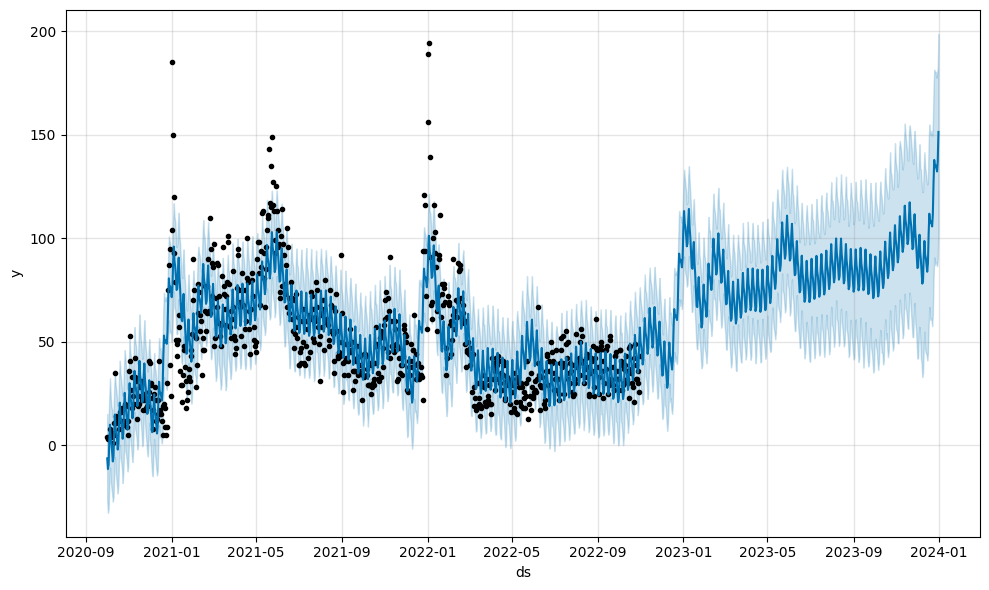

In [ ]:
from prophet import Prophet

m = Prophet()
new_users_prophet = pd.DataFrame({'ds': new_users.index, 'y': new_users.values})
m.fit(new_users_prophet)

periods = len(pd.date_range(PREDICTION_START, PREDICTION_END))
future = m.make_future_dataframe(periods=periods)
m.plot(m.predict(future));

Now, let's create a Series `new_users_pred` where we'll keep predictions for the new users amount.

In [220]:
new_users_pred = m.predict(future)\
    .assign(yhat=lambda _df: _df['yhat'].astype(int))\
    .rename(columns={'ds': 'date', 'yhat': 'count'})\
    .loc[lambda _df: _df['date'] >= PREDICTION_START]\
    .set_index('date')\
    ['count']

new_users_pred.head()

date
2022-11-01    49
2022-11-02    47
2022-11-03    43
2022-11-04    39
2022-11-05    41
Name: count, dtype: int64

### Getting the states

So we want assign one of 7 states for each day of a user's lifetime (meaning lifetime within the app). According to the definition, for each day we need to consider at least 30 days in the past. This is when SQL window functions come in. However, since `df` data contains only *active* day indicators, we need to explicitly extend it with the days when a user was not active.

For readability purposes we split the next SQL query into multiple subqueries.

- `dau`. Simply transforms dates from string to date data type.
- `full_range`. Creates a full sequence of dates for each user. 

In [58]:
DATASET_START = '2021-11-01'
DATASET_END = '2022-10-31'
OBSERVATION_START = '2021-10-01'

query = f"""
WITH
dau AS (
    SELECT
        user_id,
        date::date AS date,
        registration_date::date AS registration_date
    FROM df
),
full_range AS (
    SELECT
        user_id, UNNEST(generate_series(greatest(registration_date, '{OBSERVATION_START}'), date '{DATASET_END}', INTERVAL 1 DAY))::date AS date
    FROM (
        SELECT DISTINCT user_id, registration_date FROM dau
    )
),
dau_full AS (
    SELECT
        fr.user_id,
        fr.date,
        dau.date IS NOT NULL AS is_active,
        registration_date
    FROM full_range AS fr
    LEFT JOIN dau USING(user_id, date)
),
states AS (
    SELECT
        user_id,
        date,
        is_active,
        first_value(registration_date IGNORE NULLS) OVER (PARTITION BY user_id ORDER BY date) AS registration_date,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 6 PRECEDING and 1 PRECEDING) AS active_days_back_6d,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 29 PRECEDING and 1 PRECEDING) AS active_days_back_29d,
        CASE
            WHEN date = registration_date THEN 'new'
            WHEN is_active = TRUE AND active_days_back_6d BETWEEN 1 and 6 THEN 'current'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) > 0 THEN 'reactivated'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) = 0 THEN 'resurrected'
            WHEN is_active = FALSE AND active_days_back_6d > 0 THEN 'at_risk_wau'
            WHEN is_active = FALSE AND active_days_back_6d = 0 AND ifnull(active_days_back_29d, 0) > 0 THEN 'at_risk_mau'
            ELSE 'dormant'
        END AS state
    FROM dau_full
)
SELECT user_id, date, state FROM states
WHERE date BETWEEN '{DATASET_START}' AND '{DATASET_END}'
ORDER BY user_id, date
"""
states = duckdb.sql(query).df()

In [169]:
query = f"""
SELECT
    date,
    state_from,
    state_to,
    COUNT(*) AS cnt,
FROM (
    SELECT
        date,
        state AS state_to,
        lag(state) OVER (PARTITION BY user_id ORDER BY date) AS state_from
    FROM states
)
WHERE state_from IS NOT NULL
GROUP BY date, state_from, state_to
ORDER BY date, state_from, state_to;
"""
transitions = duckdb.sql(query).df()

In [ ]:
PREDICTION_START = '2022-11-01'
PREDICTION_END = '2023-12-31'

states_order = ['new', 'current', 'reactivated', 'resurrected', 'at_risk_wau', 'at_risk_mau', 'dormant']

def get_transition_matrix(transitions, date1, date2):
    probs = transitions\
        .loc[lambda _df: _df['date'].between(date1, date2)]\
        .groupby(['state_from', 'state_to'], as_index=False)\
        ['cnt'].sum()\
        .assign(
            supp=lambda _df: _df.groupby('state_from')['cnt'].transform('sum'),
            prob=lambda _df: _df['cnt'] / _df['supp']
        )

    M = probs.pivot(index='state_from', columns='state_to', values='prob')\
        .reindex(states_order, axis=0)\
        .reindex(states_order, axis=1)\
        .fillna(0)\
        .astype(float)

    return M


### Predicting DAU

In [ ]:
def predict_dau(M, state0, date1, date2, new_users):
    """
    Predicts DAU over a given date range.

    Parameters
    ----------
    M : pandas.DataFrame
        Transition matrix representing user state changes.
    state0 : pandas.Series
        counts of initial state of users.
    date1 : str
        Start date of the prediction period in 'YYYY-MM-DD' format.
    date2 : str
        End date of the prediction period in 'YYYY-MM-DD' format.
    new_users : int or pandas.Series
        The expected amount of new users for each day between date1 and date2.
        If a Series, it should have dates as the index.
        If an int, the same number is used for each day.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame containing the predicted DAU, WAU, and MAU for each day in the date range,
        with columns for different user states and tot.
    """
    
    dates = pd.date_range(date1, date2)
    dates.name = 'date'
    dau_pred = []
    new_dau = state0.copy()
    for date in dates:
        new_dau = (M.transpose() @ new_dau).astype(int)
        if isinstance(new_users, int):
            new_users_today = new_users
        else:
            new_users_today = new_users.astype(int).loc[date] 
        new_dau.loc['new'] = new_users_today
        dau_pred.append(new_dau.tolist())

    dau_pred = pd.DataFrame(dau_pred, index=dates, columns=states_order)
    dau_pred['dau'] = dau_pred['new'] + dau_pred['current'] + dau_pred['reactivated'] + dau_pred['resurrected']
    dau_pred['wau'] = dau_pred['dau'] + dau_pred['at_risk_wau']
    dau_pred['mau'] = dau_pred['dau'] + dau_pred['at_risk_wau'] + dau_pred['at_risk_mau']
    
    return dau_pred


def get_state0(date):
    query = f"""
    SELECT state, count(*) AS cnt
    FROM states
    WHERE date = '{date}'
    GROUP BY state
    """

    state0 = duckdb.sql(query).df()
    state0 = state0.set_index('state').reindex(states_order)['cnt']
    
    return state0


In [ ]:
M = get_transition_matrix(transitions, '2022-10-25', '2022-10-31')
state0 = get_state0(DATASET_END)
dau_pred = predict_dau(M, state0, PREDICTION_START, PREDICTION_END, new_users_pred)
dau_pred

,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant,dau,wau,mau
2022-11-01,49,444,13,13,451,1269,16795,519,970,2239
2022-11-02,47,446,13,13,462,1267,16830,519,981,2248
2022-11-03,43,448,13,13,470,1267,16865,517,987,2254
2022-11-04,39,448,13,13,474,1268,16900,513,987,2255
2022-11-05,41,447,13,13,475,1269,16935,514,989,2258
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,135,1172,34,36,1266,3247,45910,1377,2643,5890
2023-12-28,134,1187,34,36,1282,3258,45999,1391,2673,5931
2023-12-29,132,1201,34,36,1297,3271,46088,1403,2700,5971
2023-12-30,137,1213,34,36,1309,3285,46178,1420,2729,6014


<Axes: >

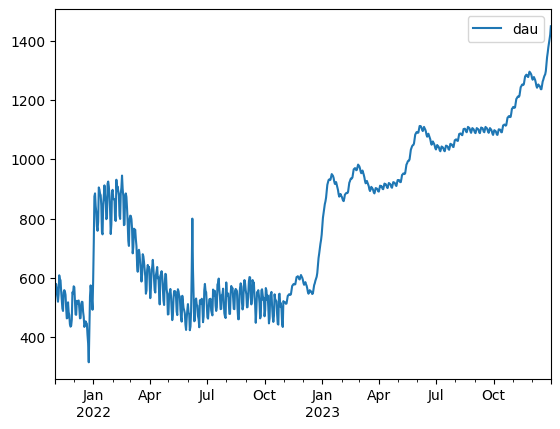

In [208]:
query = """
SELECT date, COUNT(*) AS dau
FROM states
WHERE state IN ('new', 'current', 'reactivated', 'resurrected')
GROUP BY date
ORDER BY date
"""

dau_true = duckdb.sql(query).df()\
    .set_index('date')
pd.concat([dau_true, dau_pred['dau']]).plot()

## Prediction testing

<Axes: xlabel='date'>

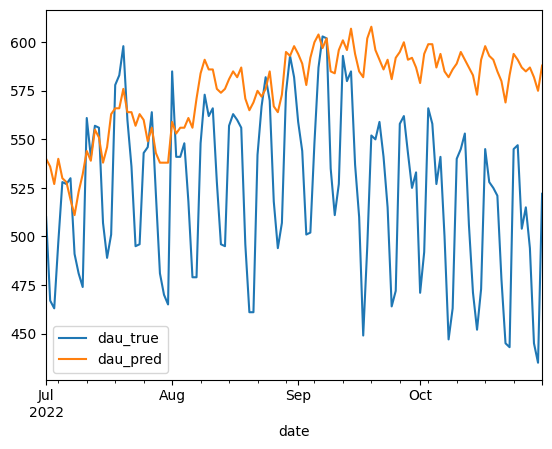

In [239]:
state0 = get_state0('2022-06-30')
M = get_transition_matrix(transitions, '2022-06-23', '2022-06-30')
dau_pred = predict_dau(M, state0, '2022-07-01', '2022-10-31', new_users)

dau_true\
    .join(dau_pred[['dau']], how='inner', lsuffix='_true', rsuffix='_pred')\
    .plot()


## Discussion

## Conclusions

